In [ ]:
pip install pyperlin

  Preparing metadata (setup.py) ... done
  Created wheel for pyperlin: filename=pyperlin-1.1.0-py3-none-any.whl size=4438 sha256=d102e76f9be659ab1dee381a47177141a2e86528759f0951dd960f4f7996e7a3
  Stored in directory: /root/.cache/pip/wheels/f9/4a/c9/162e6a34c8b0fa93f01bc5eb45dd41a6a65f895c19a4235c8c
Successfully built pyperlin


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import itertools
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from PIL import Image
from sklearn.model_selection import train_test_split

from time import process_time
from scipy.stats import gengamma, invgamma, gamma

import pyperlin
from skimage.filters import threshold_otsu
import imageio

base_dir = "."

# Functions for Generating Synthetic Data

In [ ]:
def save_dataset(data, labels, alpha1s, alpha2s, output_file=f'{base_dir}/Data/combined_alphas.npz'):
    """ Saves the generated data into a npz file for later use:
        Args:
          data (list) : list of generated data
          labels (list) : list of labels corresponding to data
          alpha1s (list) : list of alpha1s corresponding to data
          alpha2s (list) : list of alpha2s corresponding to data
          outputfile (str) : destination of saved data
    """
    data_dict = {'data': data,
               'labels': labels,
               'alpha1s' : alpha1s,
               'alpha2s' : alpha2s,
              }

    # Save the data to the NPZ file
    np.savez(output_file, **data_dict)

In [ ]:
def make_ground_truths(n_images=825, width=256, height=256):
    """ Generates a chosen number of ground truth labels using Perlin Noise
        thresholding.
        Args:
          n_images (int) : number of labels to be generated
          width (int) : width of labels
          height (int): height of labels
        Returns:
          a list of the ground truth labels
    """
    #Parameters
    persistance = .5  # Main parameter that controls the smoothness of the boundary. Should be float > 0. In practice ,< 1
    octaves = 8 # Controls level of detail. Should be integer 1-9
    lacunarity = 2  # Controls how much detail is added or removed at each octave (i.e. how zoomed in the image is). Should theoretically be integer >1, but can only get 1 and 2 to work
    shape = (width, height) # Use powers of 2 (also corresponds to octaves)
    batch_size = n_images # Num of GTs
    threshold = "auto" # Can be "auto" to use Otsu threshold or a float between 0 and 1

    output_size = (batch_size, shape[0], shape[1])
    generator = torch.Generator()
    generator.manual_seed(1)

    resolutions = [(lacunarity ** i,lacunarity ** i) for i in range(1,octaves+1)]
    factors = [persistance ** i for i in range(octaves)]
    fp = pyperlin.FractalPerlin2D(output_size, resolutions, factors, generator=generator)
    noise = fp()
    noise = noise.numpy()

    labels = []
    for generation in noise:
        if threshold == "auto":
          t = threshold_otsu(generation)
        else:
          t = threshold
        generation_t = (generation > t).astype(np.uint8)

        labels.append(generation_t)
    return labels


def make_noisy_data(alpha1, alpha2, L=1):
    """ Calls to make ground truth labels. Then, for each label, generates
        corresponding data by sampling from the generalized gamma distribution
        with the given roughness and look parameters.
        Args:
          alpha1 (float) : region 1 roughness parameter
          alpha2 (float) : region 2 roughness parameter
          L (int) : look parameter
        Returns:
          lists of the data and corresponding ground truth labels
    """
    ref_labels = make_ground_truths()
    sample_size = 1
    eps = 1e-12
    gamma1 = -alpha1 - 1
    gamma2 = -alpha2 - 1

    data = np.zeros((n_images, width, height))

    for i, label in enumerate(ref_labels):
        xx = gamma.rvs(a=L, scale=1/L, size=(width, height))
        yy1 = gamma.rvs(a=gamma1, scale=-alpha1/gamma1, size=(width, height))
        yy2 = gamma.rvs(a=gamma2, scale=-alpha2/gamma2, size=(width, height))

        #mask to combine the two regions based on ground truth
        mask = label == 1
        data[i, mask] = xx[mask] / (yy1[mask] + eps)
        data[i, ~mask] = xx[~mask] / (yy2[~mask] + eps)

    return data, ref_labels


def generate_data(save=True):
    """ Makes a list of roughness parameter permutations. Then for each
        permutation, calls to generate ground truth labels and corresponding
        synthetic data samples.
        Args:
          save (bool) : Whether to save the synthetic data to a npz file
    """
    alpha_combos = list(itertools.permutations([-1.5, -3, -5, -9, -11], 2))
    loaded_data = np.empty((0, width, height), dtype=np.float32)
    loaded_labels = np.empty((0, width, height), dtype=np.float32)
    alpha1s = []
    alpha2s = []
    for alpha1, alpha2 in alpha_combos:
        if alpha1 < alpha2:
            continue
        data, labels = make_noisy_data(alpha1=alpha1, alpha2=alpha2, L=1)
        loaded_data = np.concatenate((loaded_data, data), axis=0)
        loaded_labels = np.concatenate((loaded_labels, labels), axis=0)
        alpha1s += [alpha1] * data.shape[0]
        alpha2s += [alpha2] * data.shape[0]

    if save:
      save_dataset(loaded_data, loaded_labels, np.array(alpha1s), np.array(alpha2s))
    print(f"finished generating {loaded_data.shape[0]} data points")

generate_data()

# Code for Testing Synthetic Dataset's Ability to Train a Standard U-Net

In [ ]:
class PerlinNoiseDataset(Dataset):
    """ Dataset class for the synthetic data.
    """
    def __init__(self, x, y):
      self.x = torch.Tensor(x).float()
      self.y = torch.Tensor(y).long()

      # Take the logarithm of the tensor
      self.x = torch.log1p(self.x)

      # Normalize the tensor
      self.x = (self.x - self.x.mean()) / self.x.std()

    def __len__(self):
      """ Gets the number of images in the busses dataset.
          Returns:
            int : number of unique images in dataset
      """
      return len(self.x)

    def __getitem__(self, ix):
      """ Given an index, returns an image and its corresponding object bounding
          boxes with their associated labels.
          Args:
            idx (int) : index of busses data to retrieve
      """
      DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
      return self.x[ix].to(DEVICE), self.y[ix].to(DEVICE)

In [ ]:
def intersectionOverUnion(y_pred_in, target):
  """ Computes intersection over union metric.
      Args:
        y_pred_in (tensor) : y predictions
        target (tensor) : ground truth labels
  """
  y_pred_rounded = torch.round(y_pred_in)

  intersection = torch.logical_and(y_pred_rounded, target).sum().item()
  union = torch.logical_or(y_pred_rounded, target).sum().item()

  iou = intersection / union if union > 0 else 0.0

  return iou

In [ ]:
class conv_block(nn.Module):
    """ Helper block with convolutions to be used in U-Net.
    """
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(
            out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()


    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x


class encoder_block(nn.Module):
    """ Block with learnable convolutions and max pooling layers that is used
        to learn feature maps and reduce the spatial dimensions of the input.
        To be used in the encoder of a U-Net.
    """
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p


class decoder_block(nn.Module):
    """ Block with learnable transpose convolutions and max pooling layers that
        is used to reconstruct the original data and increase the spatial
        dimensions of the input. To be used in the decoder of a U-Net.
    """
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
  """ High-level architecture for a standard U-Net.
  """
  def __init__(self, in_channels, out_channels, drop_p=0.5):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(in_channels, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = nn.Sequential(
            conv_block(512, 1024),
        )
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, out_channels, kernel_size=1, padding=0)
        self.sigmoid = nn.Sigmoid()


  def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        outputs = self.sigmoid(outputs)
        return outputs

In [ ]:
def plot_train_test(training_set, testing_set, plot_type):
  """
  Plots loss over epochs.
  Args:
    training_set (list) : training losses or IOUs
    testing_set (list) : training losses or IOUS
    plot_type (string) : whether the plot is for loss or IOU
  """
  plt.plot(training_set, label = "Training " + plot_type)
  plt.plot(testing_set, label = "Testing " + plot_type)
  plt.xlabel("Epoch")
  plt.ylabel(plot_type)
  plt.legend()
  plt.show()

In [ ]:
class ModelRunner():
  """ Class that trains the U-Net model.
  """
  def __init__(self, model, train_dl, test_dl, epochs=70):
    """ Initialized the modelrunner.
        Args:
          model (Pytorch model) : the U-Net to be trained
          train_dl (dataloader) : allows acccess to the training dataset
          test_dl (dataloader) : allows acccess to the testing dataset
          epochs (int) : the number of times to send the training data through
                         the model
    """
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    #Hyperparameters
    self.LR = 1e-4
    self.EPOCHS = epochs
    self.LOSS_FUNC = nn.BCELoss()
    self.optimizer = Adam(model.parameters(), lr=self.LR)

    self.model = model.to(DEVICE)
    self.train_dl = train_dl
    self.test_dl = test_dl

    self.training_losses = []
    self.testing_losses = []
    self.training_ious = []
    self.testing_ious = []
    self.train_time = 0

  def train(self, do_print):
    """ Trains the model on the training dataset.
    """
    training_loss_per_epoch = []
    training_iou_per_epoch = []

    self.model.train()
    start_time = process_time()
    for data, labels in self.train_dl:
      data = data.unsqueeze(1)
      labels = labels.float()

      self.optimizer.zero_grad()
      y_pred = self.model(data).squeeze(1)
      loss = self.LOSS_FUNC(y_pred, labels)
      iou = intersectionOverUnion(y_pred, labels)
      loss.backward()
      self.optimizer.step()

      training_loss_per_epoch.append(loss.item())
      training_iou_per_epoch.append(iou)

    end_time = process_time()
    self.train_time += (end_time - start_time)

    avg_loss = np.mean(training_loss_per_epoch)
    avg_iou = np.mean(training_iou_per_epoch)
    self.training_losses.append(avg_loss)
    self.training_ious.append(avg_iou)
    if do_print:
        print("avg train loss (MSE):", avg_loss)
        print("avg train IOU:", avg_iou)

  def test(self, do_print):
    """ Tests the model on the testing dataset.
    """
    testing_loss_per_epoch = []
    testing_iou_per_epoch = []
    self.model.eval()
    for data, labels in self.test_dl:
      data = data.unsqueeze(1)#.float()
      labels = labels.float()
      with torch.no_grad():
        y_pred = self.model(data).squeeze(1)

        loss = self.LOSS_FUNC(y_pred, labels)

        iou = intersectionOverUnion(y_pred, labels)
        testing_iou_per_epoch.append(iou)
        testing_loss_per_epoch.append(loss.item())

    avg_loss = np.mean(testing_loss_per_epoch)
    avg_iou = np.mean(testing_iou_per_epoch)
    self.testing_losses.append(avg_loss)
    self.testing_ious.append(avg_iou)
    if do_print:
        print("avg test loss (MSE):", avg_loss)
        print("avg test IOU:", avg_iou)

  def display_results(self):
    """ Plots the training/testing losses and IOUs over the training cycle
        and prints the final epoch's average loss, IOU, and training time.
    """
    plot_train_test(self.training_losses, self.testing_losses, "MSE Loss")
    plot_train_test(self.training_ious, self.testing_ious, "IOU")
    print(f"Final test loss (MSE) is {self.testing_losses[-1]}")
    print(f"Final test IOU is {self.testing_ious[-1]}")
    print(f"\nTotal training time is {round(self.train_time, 2)} seconds\n")

  def get_trained_model(self):
    """ Returns the trained U-Net Model.
    """
    return self.model

  def run_loop(self):
    """ Trains and tests for a given number of epochs. Then, displays the results
        of the training.
    """
    for epoch in range(self.EPOCHS):
      do_print = epoch % 10 == 0
      if do_print:
        print(f"Running epoch {epoch + 1} out of {self.EPOCHS}")
      self.train(do_print)
      self.test(do_print)
    self.display_results()

Code for Actually Training and Testing the U-Net on the Synthetic Datset

Running model
Running epoch 1 out of 70
avg train loss (MSE): 0.3405839737998434
avg train IOU: 0.7526874412957816
avg test loss (MSE): 0.28201321406023844
avg test IOU: 0.7955302403163536
Running epoch 11 out of 70
avg train loss (MSE): 0.10190715788897262
avg train IOU: 0.92646940071901
avg test loss (MSE): 0.10847606013218562
avg test IOU: 0.9186016285214316
Running epoch 21 out of 70
avg train loss (MSE): 0.07361489139407514
avg train IOU: 0.9445991546986676
avg test loss (MSE): 0.11162053634013448
avg test IOU: 0.9149232028116956
Running epoch 31 out of 70
avg train loss (MSE): 0.050939756793430054
avg train IOU: 0.96030350557968
avg test loss (MSE): 0.10965836810923758
avg test IOU: 0.9201704384346927
Running epoch 41 out of 70
avg train loss (MSE): 0.025546591123004992
avg train IOU: 0.9798436191671116
avg test loss (MSE): 0.10546098543064934
avg test IOU: 0.9396561275775329
Running epoch 51 out of 70
avg train loss (MSE): 0.013945858757269669
avg train IOU: 0.9891131356874442
a

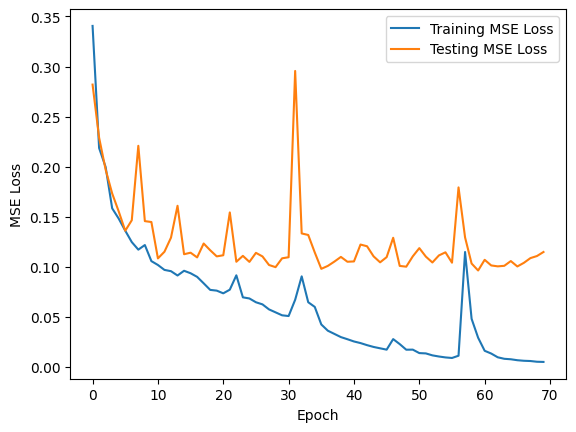

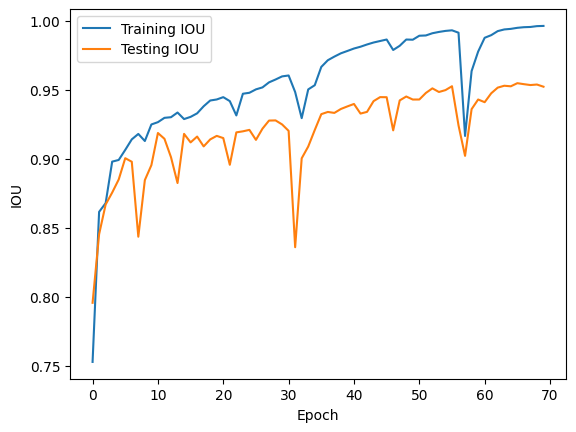

Final test loss (MSE) is 0.11487838825477022
Final test IOU is 0.9521666954722259

Total training time is 769.38 seconds



In [ ]:
def run_unet():
  """ Loads the synthetic data, the trains and tests a standard U-Net with it.
      Throughout training, displays the quantiative results.
  """
  # Load data
  image_file_path = f'{base_dir}/Data/combined_alphas.npz'
  image_data = np.load(image_file_path)

  # Get the total number of data points
  total_data_points = len(image_data['data'])

  # Use the selected indices to extract the data
  loaded_data = image_data['data']
  loaded_labels = image_data['labels']
  alpha1s = image_data['alpha1s']
  alpha2s = image_data['alpha2s']

  print(f"Loaded {len(alpha1s)} data points")

  # Split data into train and test sets
  X_train, X_test, y_train, y_test, alpha1s_train, alpha1s_test, alpha2s_train, alpha2s_test = \
      train_test_split(loaded_data, loaded_labels, alpha1s, alpha2s, test_size=0.2, random_state=42)

  BATCH_SIZE = 8

  print(f"Running model")

  train_dataset = PerlinNoiseDataset(X_train, y_train)
  train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
  test_dataset = PerlinNoiseDataset(X_test, y_test)
  test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

  unet_model = UNet(in_channels = 1, out_channels = 1)
  model_runner = ModelRunner(unet_model, train_dl, test_dl, epochs=70)
  model_runner.run_loop()
  trained_model = model_runner.get_trained_model()
  torch.save(trained_model.state_dict(), f'{base_dir}/Models/combined_alphas_unet.pth')

run_unet()

Code for Testing Synthetically-Trained U-Net on Synthetic and Real SAR Data



Testing Examples:
alpha1 = -6.0, alpha2 = -7


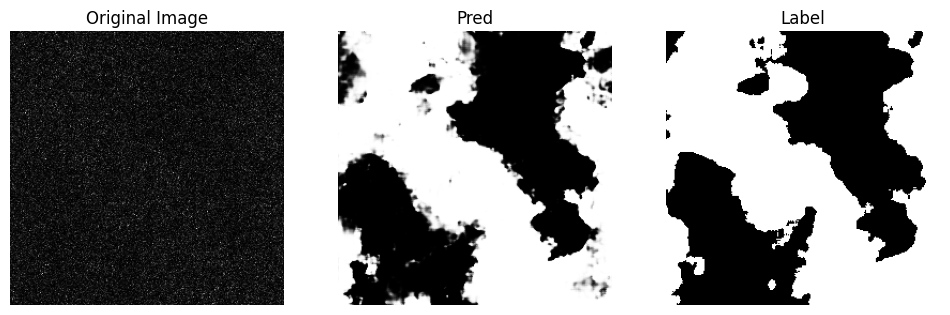

alpha1 = -2.0, alpha2 = -4


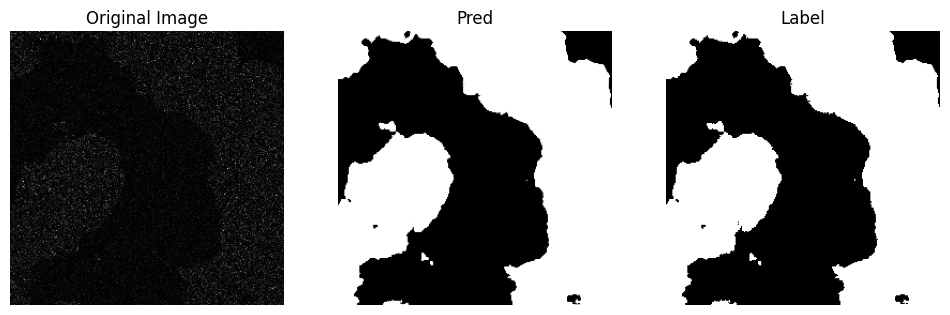

alpha1 = -1.5, alpha2 = -6


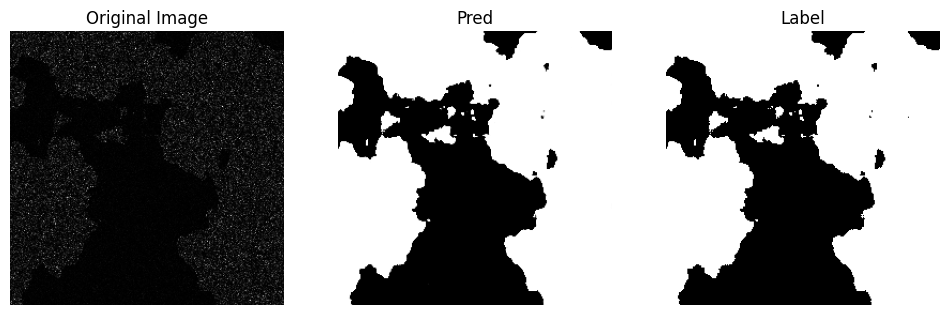

alpha1 = -2.0, alpha2 = -4


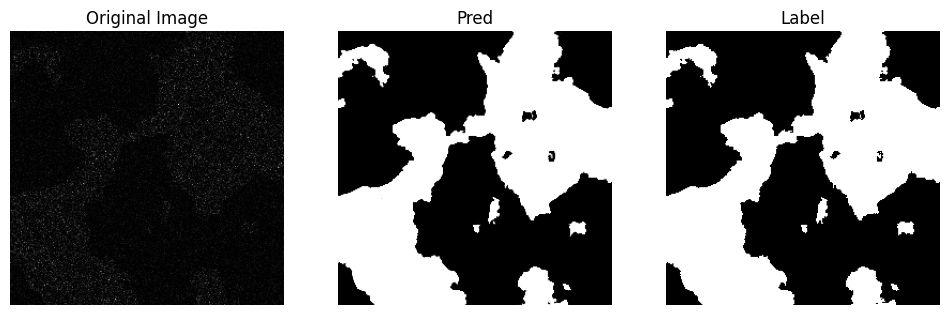

alpha1 = -2.0, alpha2 = -11


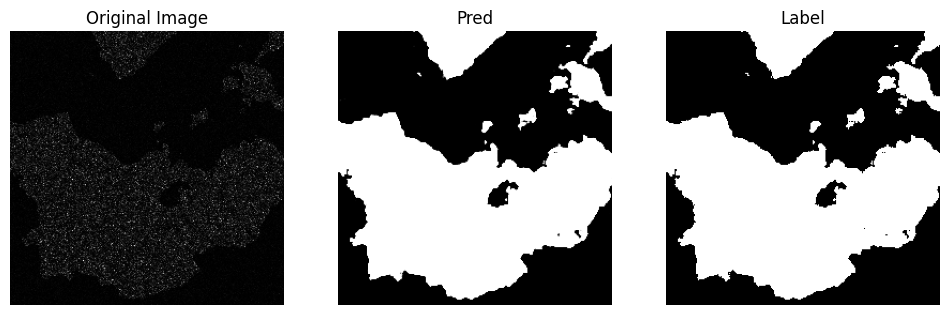

In [ ]:
def make_plots(data, labels, trained_model, alpha1s, alpha2s):
   """ Displays side-by-side plots of synthetic validation data, the resulting
       segmentation, and the corresponding ground truth label.
   """
    y_pred = trained_model(data.unsqueeze(1))
    for i in range(len(data)):
        d = data[i]
        l = labels[i]
        y = y_pred[i]
        alpha1 = alpha1s[i]
        alpha2 = alpha2s[i]

        print(f"alpha1 = {alpha1}, alpha2 = {alpha2}")

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        # Display the original image
        d = d.cpu().numpy()
        axes[0].imshow(d, cmap='gray')
        axes[0].set_title('Original Image')
        axes[0].axis('off')

        # Display prediction
        y = y.squeeze(0).cpu().detach().numpy()
        axes[1].imshow(y, cmap='gray')
        axes[1].set_title('Pred')
        axes[1].axis('off')

        # Display Label
        l = l.cpu().numpy()
        axes[2].imshow(l, cmap='gray')
        axes[2].set_title('Label')
        axes[2].axis('off')

        plt.show()

def show_results():
    """ Retrieves a U-Net trained on the synthetic data and tests it on 5
        validation synthetic images that the model has not yet seen
    """
    BATCH_SIZE = 8
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    n_images = 5

    train_dataset = PerlinNoiseDataset(X_train[:n_images], y_train[:n_images])
    train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dataset = PerlinNoiseDataset(X_test[:n_images], y_test[:n_images])
    test_dl = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # load pretrained model
    trained_model = UNet(in_channels = 1, out_channels = 1)
    trained_model.load_state_dict(torch.load(f'{base_dir}/Models/combined_alphas_unet.pth'))
    trained_model = trained_model.to(DEVICE)
    trained_model.eval()

    with torch.no_grad():
        ### Uncomment to also plot training example segmentations
        # print("Training Examples:")
        # for data, labels in train_dl:
        #     make_plots(data, labels, trained_model, alpha1s_train[:n_images], alpha2s_train[:n_images])

        print("\n\nTesting Examples:")
        for data, labels in test_dl:
            make_plots(data, labels, trained_model, alpha1s_test[:n_images], alpha2s_test[:n_images])

show_results()